In [1]:
import torch

import matplotlib.pyplot as plt
import numpy as np

import ray
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch

from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler

import seaborn as sns
import torchmetrics.classification as tc

from functions.dl.convenience_functions import to_device, trialDir
from functions.dl.data_classes import SpectroDataset, CombinedSpectroDataset, SpectroDataLoader
from functions.dl.data_functions import splitDataset, load_data, load_model, train_model, getBestModel
from functions.dl.network_components import EarlyStopping, AudioToLogSpectrogram, AudioToMelSpectrogram, AudioToMFCCSpectrogram
from functions.processing.retrieval import loadPT

ray.init(ignore_reinit_error=True)
print("Ray is initialized!")

CUDA_LAUNCH_BLOCKING=1
TORCH_USE_CUDA_DSA = 1
%load_ext tensorboard

f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2026-01-09 14:43:26,952	INFO worker.py:2007 -- Started a local Ray instance.


Ray is initialized!


f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\ray\_private\worker.py:2046: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
# https://medium.com/biased-algorithms/hyperparameter-tuning-with-ray-tune-pytorch-d5749acb314b
max_epochs = 25
# Define hyperparameter search space
config = {
    "lr": tune.loguniform(1e-5, 1e-2),          # Learning rate between 1e-5 and 1e-2
    # "batch_size": tune.lograndint(8, 16), # for small batch testing
    "batch_size": tune.lograndint(32, 128),
    "nfft" : tune.choice([512, 1024, 2048, 4096, 8192]),
    # "scale" : tune.uniform(0.5, 4),
    "power" : tune.uniform(0.5, 4),
    "patience" : tune.choice([2, 3, 5, 7, 9]),
    "EarlyDelta" : tune.uniform(0.0015, 0.1),
    "epochs" : tune.randint(15, max_epochs),
    "l1" : tune.loguniform(0.0005, 0.004),
    "l2" : tune.loguniform(0.00075, 0.003),
    "nmels" : tune.randint(64, 256),
    "nmfcc" : tune.randint(32, 128)
    #"optimizer": tune.choice(["adam", "sgd"]),  # Optimizer choice: Adam or SGD
    # "layer_size": tune.randint(64, 256),        # Random integer for layer size (hidden units)
    # "dropout_rate": tune.uniform(0.1, 0.5)      # Dropout rate between 0.1 and 0.5
}

In [4]:
def getSamples(split : list, sizes : list = [None, None, None]):
    """
        Computes the indices for the datasets used in the dataloader. Intended to be used after the splitDataset method.

        Inputs:
            split : list - list containing indices of the train, test and val splits
            sizes : list - list containing the number of samples. Uses absolute samples when given an int, percentage for float <= 1 and all sample for None type

        Outputs: 
            samples : list - list containing the split indices
    """
    samples = []
    for idx, data in enumerate(split):
        data_indices = []
        if type(sizes[idx]) is int:
            data_indices = split[idx][:sizes[idx]]
        elif (type(sizes[idx]) is float and sizes[idx] <= 1.0):
            indices = round(len(split[idx])*sizes[idx])
            data_indices = split[idx][:indices]
        elif sizes[idx] is None:
            data_indices = split[idx]
        
        samples.append(data_indices)
        
    return samples

In [ ]:
concurrent_trials = 2

# Load  dataset
# recording_path= "F:\\Persönliches\\Git\\BioOTon\\AudioTensors_denoised"# "F:\\Persönliches\\Git\\BioOTon\\AudioTensors_freq"# "F:\\Persönliches\\Git\\BioOTon\\AudioTensors"
# label_path="F:\\Persönliches\\Git\\BioOTon"
# ds = SpectroDataset(recording_path, label_path, device = 'cuda', denoised = True, filtered=False)

# File locations for the label files
dawn_file = "F:/Persönliches/Git/BioOTon/points_single.parquet"
xeno_file = "F:/Persönliches/Git/BioOTon/xeno_points_single.parquet"
augmented_file = "F:/Persönliches/Git/BioOTon/augmented_points_single.parquet"

# The train - test - validation split
train_split_pct = 0.7
val_split_pct = 0.1
test_split_pct = 1.0 - train_split_pct - val_split_pct

# If and how many samples to take from the dataset
train_sample_size = 0.01
test_sample_size = 0.01
val_sample_size = 0.01


ds = CombinedSpectroDataset(dawn_file, xeno_file, augmented_file, device = device, denoised = True)

split = splitDataset(ds, test_split_size=val_split_pct, val_split_size=test_split_pct)
train_indices, test_indices, val_indices = getSamples(split, sizes = [train_sample_size, test_sample_size, val_sample_size])


trainable_with_parameters = tune.with_parameters(
    train_model, dataset=ds, spectro_mode = "atmfs", split = [train_indices, val_indices] #train_size = int(np.floor(0.7 * len(ds))), val_size = int(np.floor(0.1 * len(ds)))# train_size=500, val_size=100
)

trainable_with_resources = tune.with_resources(
    trainable_with_parameters,
    resources={"cpu": 6/concurrent_trials, "gpu": 1/concurrent_trials, "accelerator_type:G":1/concurrent_trials}
)

optuna_search = OptunaSearch(
    metric=["loss", "accuracy"],
    mode=["min", "max"]
)

# Currently unused
hyperopt_search = HyperOptSearch(
    metric="loss",
    mode="min",  # Minimize loss
    # points_to_evaluate # Use when some good hyperparameters are known as initial values
)

asha_scheduler = ASHAScheduler(
    time_attr='training_iteration',
    metric='accuracy',
    mode='max',
    max_t=max_epochs,
    grace_period=10,
    brackets=1,
)

# Pass the search algorithm to Ray Tune
tuner = tune.Tuner(
    trainable_with_resources,
    param_space=config,
    # tune_config=tune.TuneConfig(search_alg=hyperopt_search, num_samples=50, trial_dirname_creator=trialDir, max_concurrent_trials=2),
    tune_config=tune.TuneConfig(search_alg=optuna_search, num_samples=50, trial_dirname_creator=trialDir, max_concurrent_trials=concurrent_trials,),
    run_config=tune.RunConfig(storage_path='D:/ProgramFiles/RayResults', name="results")
)
tuner.fit()

(pid=gcs_server) [2026-01-09 14:43:54,923 E 432 6720] (gcs_server.exe) gcs_server.cc:303: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(raylet) [2026-01-09 14:43:59,307 E 31128 26464] (raylet.exe) main.cc:1032: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(train_model pid=25588) Number of MFCC bins cannot be greater than number of Mel bins. Changing to a smaller number.
(train_model pid=25588) Getting index 61330, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\19446334_audio_dn.pt
(train_model pid=25588) Getting index 60479, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\27634890_audio_dn.pt
(train_model pid=25588) Getting index 61551, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_878111_audio_dn.pt
(train_model pid=25588) Getting index 61439, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_28303797_audio_dn.pt
(train_model pid=25588) Getting index 60348, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_23522928_audio_dn.pt
(train_model pid=25588) Getting index 61537, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_29078300_audio_dn.pt
(train_model pid=25588) Getting index 61570, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_22926119_audio_dn.pt
(train_model pid=25588) Getting index 61157, F:\

In [ ]:
model, df = getBestModel(return_df=True)

In [ ]:
# Plot loss vs learning rate
sns.scatterplot(x="config/lr", y="loss", data=df)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate vs Loss")
plt.show()

In [ ]:
%tensorboard --logdir runs/single_points/

In [ ]:
train_indices, test_indices, val_indices  = splitDataset(ds)
test_dataloader = SpectroDataLoader(ds, batch_size, samples= test_indices[:150], device = "cuda")

Getting F:\Persönliches\Git\BioOTon\AudioTensors\23857077_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\22294964_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\26223311_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\22294960_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\22329529_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\26574358_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\22303197_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\23848329_audio.pt
Best Hyperparameters: {'lr': 0.00018217292899600795, 'batch_size': 2, 'nfft': 4096, 'scale': 3.3285967358612116, 'power': 1.7831184599879397, 'patience': 9, 'EarlyDelta': 0.0549733297167698, 'epochs': 17, 'l1': 0.003237281614796639, 'l2': 0.0015806433029207302}
Getting F:\Persönliches\Git\BioOTon\AudioTensors\22398674_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\22398677_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\22370546_audio.pt
G

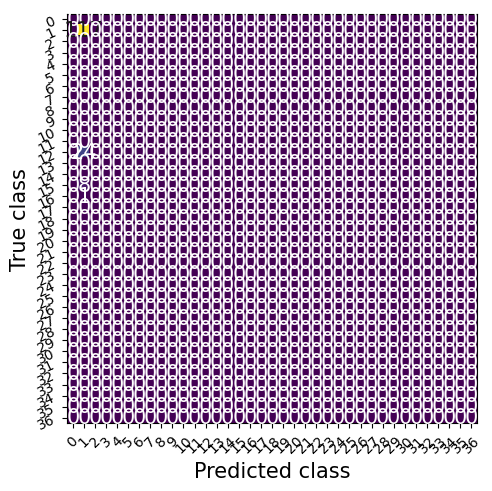

Recall of the custom cnn: tensor(0.2500, device='cuda:0')
F1-score of the custom cnn: tensor(0.2191, device='cuda:0')
Overall accuracy of the custom cnn: tensor(0.2500, device='cuda:0')


In [ ]:
preds = torch.Tensor().to(device)
labs = torch.Tensor().to(device)

# Get predictions and corresponding real labels
with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data
        model = getBestModel()
        inp = model(inputs)

        preds = torch.cat((preds, inp), 0).to(device)
        labs = torch.cat((labs, labels), 0)
        labs = labs.type(torch.LongTensor).to(device)


# Confusion Matrix
metric = tc.MulticlassConfusionMatrix(37).to(device)
metric.update(preds, labs)

fig_, ax_ = metric.plot()
plt.show()


# Compute recall
recall = tc.Recall(task="multiclass", average='macro', num_classes=37).to(device)
recall(preds, labs)
print("Recall of the custom cnn:", recall.compute())

# Compute F1-score
f1 = tc.MulticlassF1Score(37).to(device)
f1(preds, labs)
print("F1-score of the custom cnn:", f1.compute())


# Compute overall accuracy
oa = tc.MulticlassAccuracy(37).to(device)
oa(preds, labs)
print("Overall accuracy of the custom cnn:", oa.compute())